In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/My\ Drive/2000_fold3_new.zip
!unzip drive/My\ Drive/Test_2000_new.zip

Streaming output truncated to the last 5000 lines.
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/91361-31932.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/126841-58542.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/130389-62090.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/33706-37254.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/27497-54994.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/104666-53220.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/116197-52333.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998

In [ ]:
#related modules 
import keras
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,auc
from sklearn.metrics import average_precision_score
import tensorflow as tf
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import os
import glob
import pandas as pd
from fnmatch import fnmatch

In [ ]:
train_path = "/content/2000_fold3_new/Train"
val_path = "/content/2000_fold3_new/Validation"
test_path ="/content/Test_2000_new"

batch_size = 32

loss_function ='categorical_crossentropy'
epoch = 50

file_pattern = "*.jpg"
folder_pattern = "*TCGA-*"

#reading train and validation data
data_generator = ImageDataGenerator(rescale = 1./255)
#loop and iterating through train images
train_data_generator = data_generator.flow_from_directory(train_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle =True)
#iterating through images of validation set
val_data_generator = data_generator.flow_from_directory(val_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle = True)
#class wight balance

#class wight balance
# classes = train_data_generator.classes
class_weights_list = class_weight.compute_class_weight('balanced',np.unique(train_data_generator.classes),train_data_generator.classes)
weights = dict(zip(np.unique(train_data_generator.classes),class_weights_list))
print("weights ratio to make the dataset balanced: ",weights)

print("class Indices of train generator :",train_data_generator.class_indices)
print("class Indices of validation generator :",val_data_generator.class_indices)

Found 118309 images belonging to 2 classes.
Found 29393 images belonging to 2 classes.
weights ratio to make the dataset balanced:  {0: 0.6556622072466499, 1: 2.1060417260039874}
class Indices of train generator : {'Epithelioid': 0, 'Nonepithelioid': 1}
class Indices of validation generator : {'Epithelioid': 0, 'Nonepithelioid': 1}


In [ ]:
#this function takes the each patch in WSI then predicts the probability score
def pred_each_patch(path,name):
    y = image.load_img(os.path.join(path, name))
    img = image.img_to_array(y)
    y = np.expand_dims(img, axis = 0)
    # y = preprocess_input(y)
    y /= 255
    y_pred = model.predict(y)
    return y_pred
        
def avg(predlist):
    average = sum(predlist)/len(predlist)
    return average

def extract_index_one_frmpred(prediction_list):               
    ypred = np.stack(prediction_list)#we are vertically stacking the predictions
    ypred = np.reshape(ypred, [len(prediction_list),2])#reshaping to 100,2 - np array
    for each in ypred:
    #after reshaping the predictions as we wanted, we are taking the index '1' to compute whole slide level AUC-ROC
        val = each[1]
        pred_prob_list.append(val)#appending all the values into a list - to compute average values of single WSI and maximum of single WSI.
        
    return pred_prob_list
    
def plt_history(history): 
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.tight_layout() 
    plt.show()
    return

def y_labels(path):
  if "Epithelioid" in path:
    y_test_labels.append(0.0)
  elif "Nonepithelioid" in path:
    y_test_labels.append(1.0) 
  return

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#buiding a model with learning rate
from keras.models import load_model,Model

def resnet( ):

  model_new = base_model.output
  model_new = Flatten(name="flatten")(model_new)
  model_new = Dense(2, activation="softmax")(model_new) 

  model = Model(inputs= base_model.input, outputs= model_new)
 
  return model

Epoch 1/50
3698/3698 [==============================] - 1450s 389ms/step - loss: 0.7732 - auc: 0.7225 - accuracy: 0.6608 - val_loss: 0.7746 - val_auc: 0.7166 - val_accuracy: 0.6628
Epoch 2/50
3698/3698 [==============================] - 1441s 390ms/step - loss: 0.2999 - auc: 0.9431 - accuracy: 0.8674 - val_loss: 0.8889 - val_auc: 0.7478 - val_accuracy: 0.6817
Epoch 3/50
3698/3698 [==============================] - 1441s 390ms/step - loss: 0.1325 - auc: 0.9888 - accuracy: 0.9479 - val_loss: 0.9711 - val_auc: 0.7836 - val_accuracy: 0.7243
Epoch 4/50
3698/3698 [==============================] - 1442s 390ms/step - loss: 0.0645 - auc: 0.9976 - accuracy: 0.9777 - val_loss: 1.1448 - val_auc: 0.7760 - val_accuracy: 0.7164
Epoch 5/50
3698/3698 [==============================] - 1442s 390ms/step - loss: 0.0404 - auc: 0.9991 - accuracy: 0.9868 - val_loss: 1.3005 - val_auc: 0.7846 - val_accuracy: 0.7263
Epoch 6/50
3698/3698 [==============================] - 1443s 390ms/step - loss: 0.0281 - auc: 

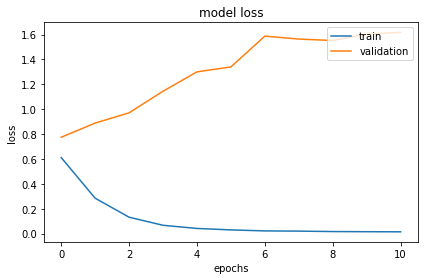

In [ ]:
model = resnet()

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-5),
                loss = 'categorical_crossentropy',metrics=[keras.metrics.AUC(name='auc'),'accuracy'])


# early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss',verbose=1, patience= 10)

#training the model
history = model.fit(train_data_generator, epochs = 50, validation_data = (val_data_generator), class_weight = weights,callbacks = [es])

plt_history(history)

**Evaluation on Validation Set**

In [ ]:
AVG_LIST_PREDICTIONS_VAL = []
MAX_LIST_PREDICTIONS_VAL = []
y_val_labels= []
print("Prediction on validation data using aggregation method")
for path, subdirs, files in os.walk(val_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        if "Epithelioid" in path:
          y_val_labels.append(0.0)
        elif "Nonepithelioid" in path:
          y_val_labels.append(1.0) 

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS_VAL.append(avg(predictions))
        MAX_LIST_PREDICTIONS_VAL.append(max(predictions))

Prediction on validation data using aggregation method


AUC - ROC on validation data average prediction scores: 0.8625
-----------------------------------------------------


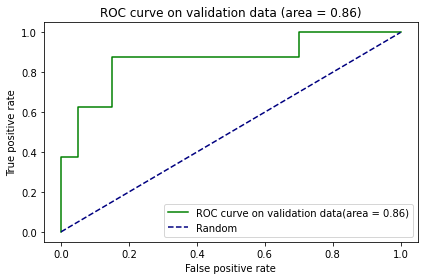

In [ ]:
false_pr_avg,true_pr_avg,threshold = roc_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on validation data average prediction scores:",roc_auc_avg)
print("-----------------------------------------------------")
plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

AUC - ROC on validation data maximum prediction scores: 0.621875
-----------------------------------------------------


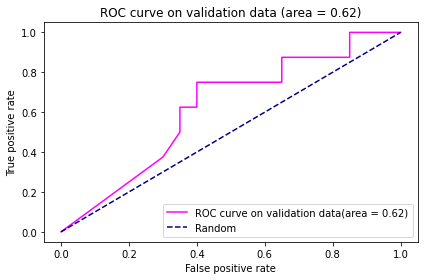

In [ ]:
false_pr_max,true_pr_max,threshold = roc_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
roc_auc_max = auc(false_pr_max,true_pr_max)
print("AUC - ROC on validation data maximum prediction scores:",roc_auc_max)
print("-----------------------------------------------------")
plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Presicion - Recall auc on validation data average score predictions: 0.7836647727272728
-----------------------------------------------------


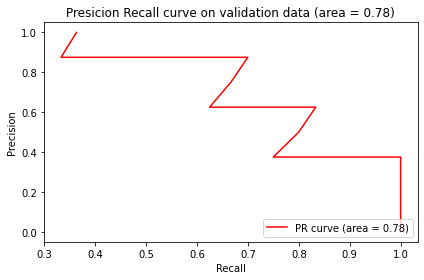

Presicion - Recall auc on validation data maximum score predictions: 0.47299473005065107
-----------------------------------------------------


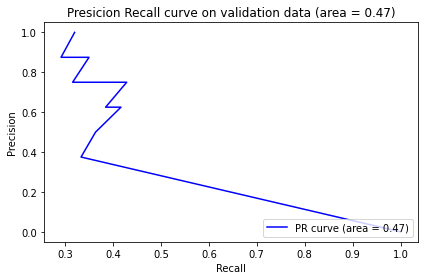

In [ ]:
#presicion - recall curve
precision, recall, threshold = precision_recall_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data average score predictions:",auc(recall,precision))
 
print("-----------------------------------------------------")
plt.plot(precision, recall,color='red',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall,precision)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

precision_max, recall_max, threshold = precision_recall_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data maximum score predictions:",auc(recall_max,precision_max))
print("-----------------------------------------------------")
plt.plot(precision_max, recall_max,color='blue',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [ ]:
import sklearn
#classification report on average prediction values
AVG_LIST_PREDICTIONS_VAL = [round(x) for x in AVG_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,AVG_LIST_PREDICTIONS_VAL))

print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")

#classification report on maximum prediction values
MAX_LIST_PREDICTIONS_VAL = [round(x) for x in MAX_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,MAX_LIST_PREDICTIONS_VAL))

CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        20
         1.0       1.00      0.38      0.55         8

    accuracy                           0.82        28
   macro avg       0.90      0.69      0.72        28
weighted avg       0.86      0.82      0.79        28

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       1.00      0.05      0.10        20
         1.0       0.30      1.00      0.46         8

    accuracy                           0.32        28
   macro avg       0.65      0.53      0.28        28
weighted avg       0.80      0.32      0.20        28



**Evaluation on Test Set**

In [ ]:
AVG_LIST_PREDICTIONS = []
MAX_LIST_PREDICTIONS = []
y_test_labels= []
print("Prediction on test using aggregation method")
for path, subdirs, files in os.walk(test_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        y_labels(path)

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        AVG_LIST_PREDICTIONS.append(avg(predictions))
        MAX_LIST_PREDICTIONS.append(max(predictions))

Prediction on test using aggregation method


In [ ]:
#AUC - ROC score
false_pr_avg,true_pr_avg,threshold = roc_curve(y_test_labels,AVG_LIST_PREDICTIONS)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on Test data average prediction scores:",roc_auc_avg)

AUC - ROC on Test data average prediction scores: 0.6


-----------------------------------------------------


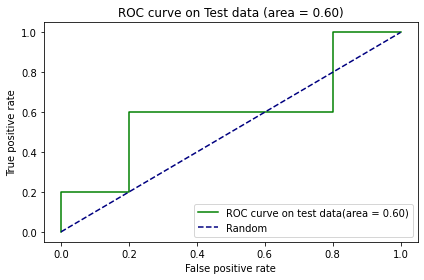

In [ ]:
print("-----------------------------------------------------")
plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [ ]:
false_pr_max,true_pr_max,threshold = roc_curve(y_test_labels,MAX_LIST_PREDICTIONS)
roc_auc_max = auc(false_pr_max,true_pr_max)
print("AUC - ROC on Test data maximum prediction scores:",roc_auc_max)

AUC - ROC on Test data maximum prediction scores: 0.665


-----------------------------------------------------


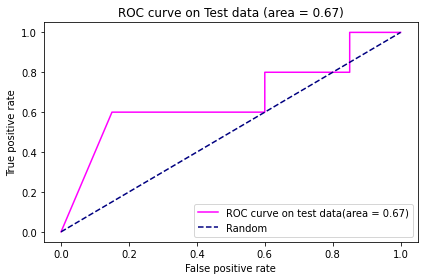

In [ ]:
print("-----------------------------------------------------")
plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Presicion - Recall auc on test data average score predictions: 0.4091228070175439
-----------------------------------------------------


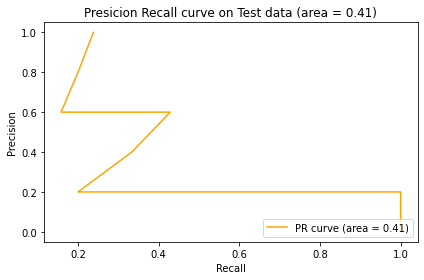

In [ ]:
#presicion - recall curve
precision, recall, threshold = precision_recall_curve(y_test_labels,AVG_LIST_PREDICTIONS)
print("Presicion - Recall auc on test data average score predictions:",auc(recall,precision))
print("-----------------------------------------------------")
plt.plot(precision, recall,color='orange',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall,precision)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Presicion - Recall auc on test data maximum score predictions: 0.5367748917748918
-----------------------------------------------------


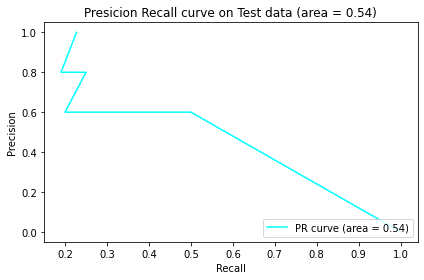

In [ ]:
precision_max, recall_max, threshold = precision_recall_curve(y_test_labels,MAX_LIST_PREDICTIONS)
print("Presicion - Recall auc on test data maximum score predictions:",auc(recall_max,precision_max))
print("-----------------------------------------------------")
plt.plot(precision_max, recall_max,color='cyan',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
AVG_LIST_PREDICTIONS = [round(x) for x in AVG_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT")
print(classification_report(y_test_labels,AVG_LIST_PREDICTIONS))
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
MAX_LIST_PREDICTIONS = [round(x) for x in MAX_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT for MAX VALUE PREDICTIONS")
print(classification_report(y_test_labels,MAX_LIST_PREDICTIONS))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82        20
         1.0       0.33      0.40      0.36         5

    accuracy                           0.72        25
   macro avg       0.59      0.60      0.59        25
weighted avg       0.74      0.72      0.73        25

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
CLASSIFICATION REPORT for MAX VALUE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.20      1.00      0.33         5

    accuracy                           0.20        25
   macro avg       0.10      0.50      0.17        25
weighted avg       0.04      0.20      0.07        25



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SAVING THE PREDICTIONS**

In [ ]:
#creating a datframe to save predictions with actuals
df = pd.DataFrame()
df['Average'] = AVG_LIST_PREDICTIONS
df['Maximum'] = MAX_LIST_PREDICTIONS
df['Actual labels'] = y_test_labels
#saving into csv file for futher use
df.to_csv('fold3_2000_kerastuner_test_res50.csv',index = False,header = True)
!cp fold3_2000_kerastuner_test_res50.csv "drive/My Drive/"

In [ ]:
#creating a datframe to save predictions with actuals
df_val = pd.DataFrame()
df_val['Average'] = AVG_LIST_PREDICTIONS_VAL
df_val['Maximum'] = MAX_LIST_PREDICTIONS_VAL
df_val['Actual labels'] = y_val_labels
#saving into csv file for futher use
df_val.to_csv('fold3_2000_kerastuner_val_res50.csv',index = False,header = True)
!cp fold3_2000_kerastuner_val_res50.csv "drive/My Drive/"

In [ ]:
#saving the model
model.save("fold3_2000_kerastuner_res50.h5")
!cp fold3_2000_kerastuner_res50.h5 "drive/My Drive/"